100%|██████████| 137M/137M [00:12<00:00, 11.7MB/s] 



0: 640x640 13 persons, 1511.0ms
1: 640x640 4 persons, 1 umbrella, 2 handbags, 1511.0ms
2: 640x640 4 persons, 1 backpack, 1 skateboard, 1511.0ms
3: 640x640 1 person, 1511.0ms
Speed: 8.4ms preprocess, 1511.0ms inference, 10.5ms postprocess per image at shape (1, 3, 640, 640)


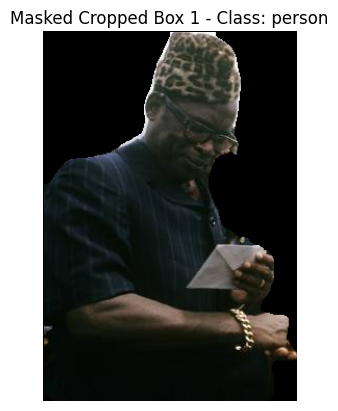

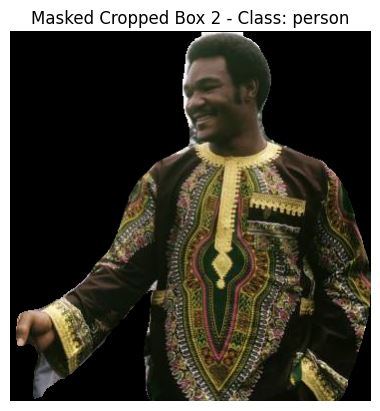

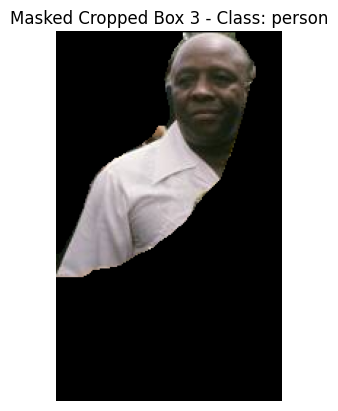

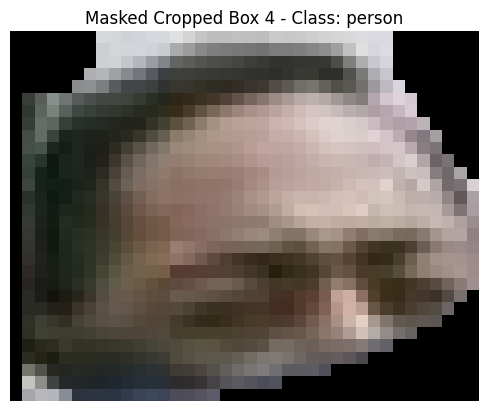

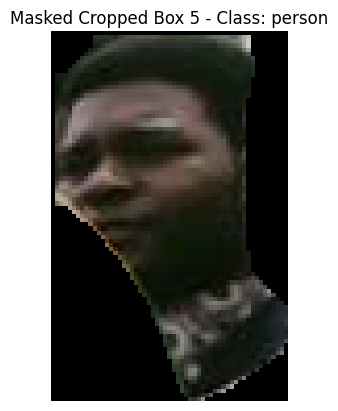

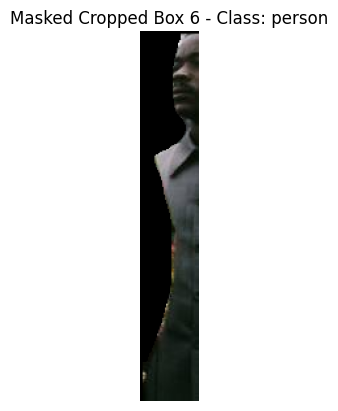

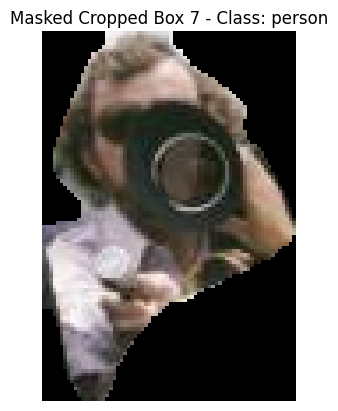

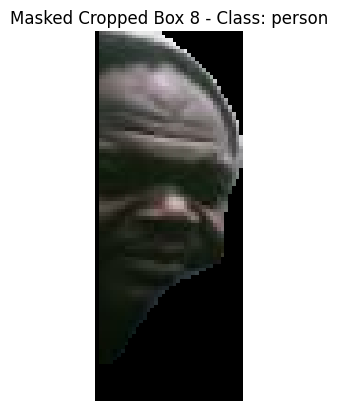

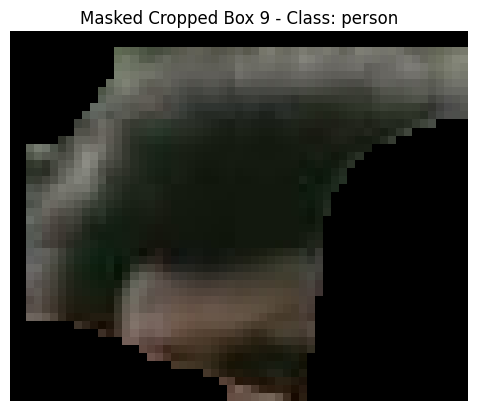

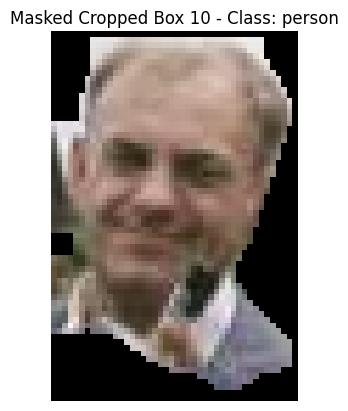

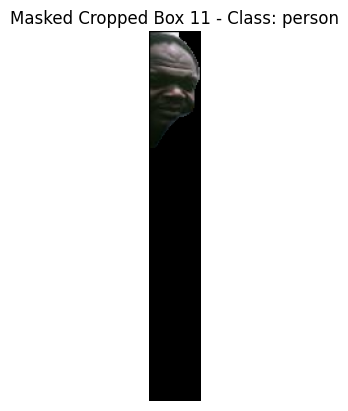

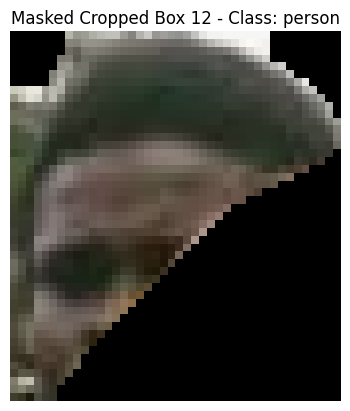

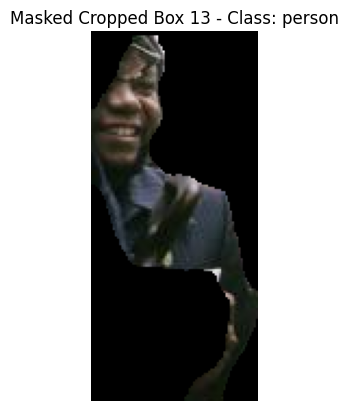

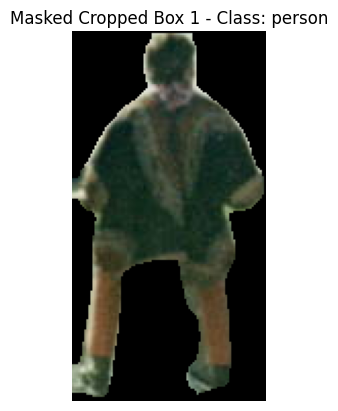

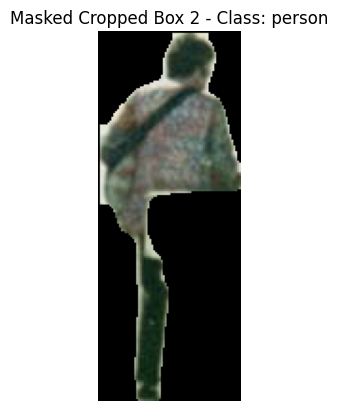

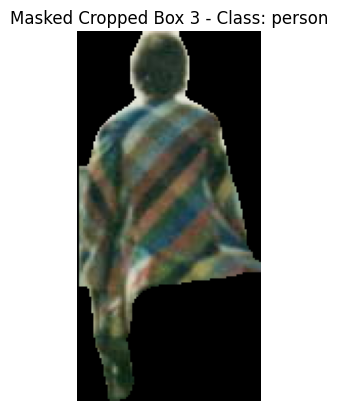

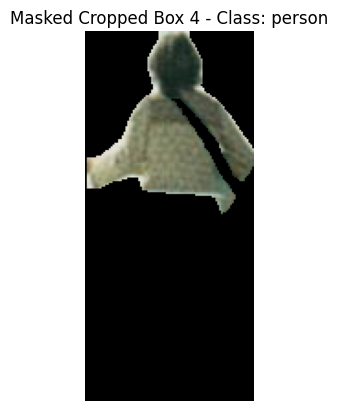

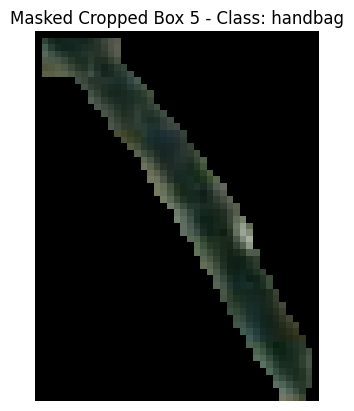

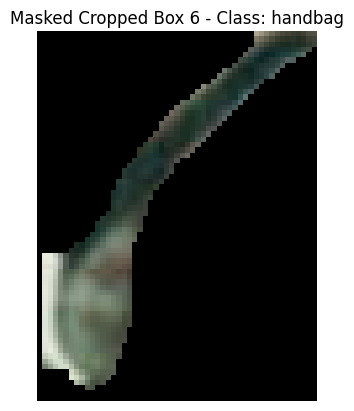

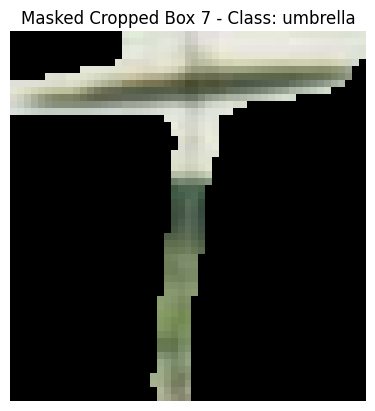

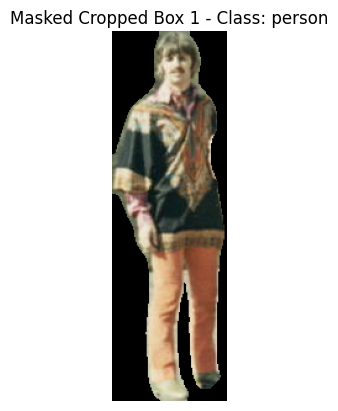

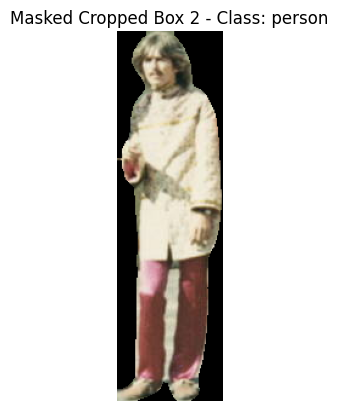

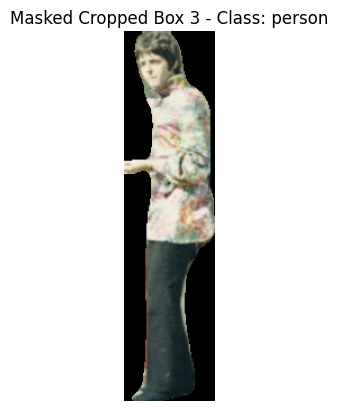

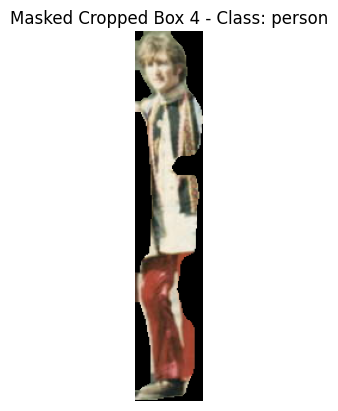

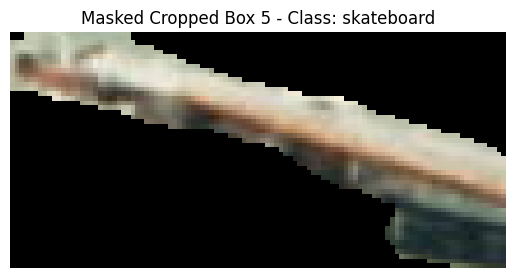

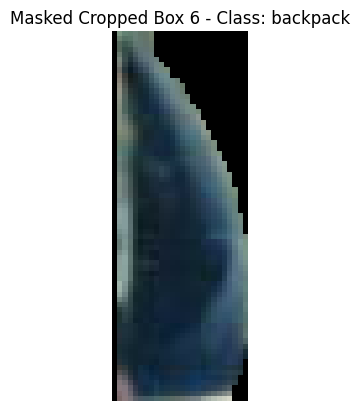

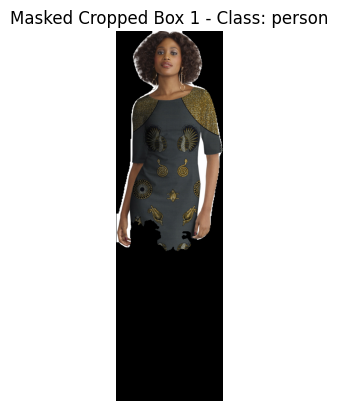

In [2]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load a model
model = YOLO("yolov8x-seg.pt")  # pretrained YOLOv8n model

# Run batched inference on a list of images
image_paths = ["../data/X.jpg", "../data/Y.jpg", "../data/YY.jpg", "../data/Z.jp2"]
results = model(image_paths)  # return a list of Results objects

# Process results list
for img_path, result in zip(image_paths, results):
    image = cv2.imread(img_path)
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for instance segmentation masks
    class_names = result.names  # Class names for the detected objects
    
    if masks is not None:
        for idx, (box, mask) in enumerate(zip(boxes, masks)):
            x1, y1, x2, y2 = map(int, box.xyxy[0])  # Get coordinates of the bounding box
            
            mask_np = mask.data.squeeze(0).cpu().numpy()  # Convert mask to NumPy array
            mask_coords = mask.xy[0]  # Get mask coordinates
            
            # Create a blank mask with the same dimensions as the original image
            blank_mask = np.zeros(image.shape[:2], dtype=np.uint8)
            
            # Fill the blank mask with the mask coordinates
            cv2.fillPoly(blank_mask, [mask_coords.astype(np.int32)], 1)
            
            # Apply the mask to the original image
            masked_image = cv2.bitwise_and(image, image, mask=blank_mask)
            
            # Crop the masked image using the bounding box coordinates
            cropped_masked_img = masked_image[y1:y2, x1:x2]
            
            # Get the predicted class name
            class_id = int(box.cls[0])
            class_name = class_names[class_id]
            
            # Display the masked cropped image with the class name in the title
            plt.imshow(cv2.cvtColor(cropped_masked_img, cv2.COLOR_BGR2RGB))
            plt.title(f'Masked Cropped Box {idx+1} - Class: {class_name}')
            plt.axis('off')
            plt.show()
    else:
        print("No masks detected.")